## Планы:
1. Гауссианы?
2. Нейронки из статей
3. Автоэнкодер?
4. Бустинг градиентный
5. Какой-нибудь другой feature engineering?
6. Посмотреть ROC AUC
7. Проверить устойчивость модели при изменении интенсивности!

## Выводы:
1. Данные становятся менее информативными при урезании/дополнении пиков, что отражается на качестве работы модели
2. Добавление в датасет информации и количестве значимых гауссианов ухудшает качество, что может свидетельствовать о возможно неправильном алгоритме разделения гауссианов на значимые и незначимые

## Инструкция для запускающих:
Инстукция предназначена для запуска на сервере 192.168.17.10
1. Убедись, что в качестве kernel'а выбрано raman-spec

In [1]:
# !pip install -U yellowbrick

In [137]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
# plt.rc('xtick', labelsize=10) 
# plt.rc('ytick', labelsize=10) 
# plt.rc('axes', labelsize=15)
# plt.rc('figure', titlesize=20)

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import (
    cross_val_score, 
    cross_validate, 
    train_test_split
)

import random

from sklearn import svm, datasets
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
# peaks search by gauss decomposition
# import gausspy
# import gausspy.gp as gp
# import pickle

from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier


In [138]:
torch.cuda.is_available()

False

In [139]:
# !pip install plotly
# !pip install pandas
# !conda install pytorch torchvision torchaudio -c pytorch -y
# !pip install -U scikit-learn

## Data loading/proccessing

Загрузка данных

In [140]:
# # для работы в колабе 
# from google.colab import drive
# drive.mount('/content/drive')

### 38 peaks data proccessing

In [141]:
fixed_fg_file, fixed_ga_file = "dataSrc/peaks-fg-38nonsign.csv", "dataSrc/peaks-ga-38nonsign.csv"

data_fixed_fg = pd.read_csv(fixed_fg_file, sep=";", header=None)
data_fixed_ga = pd.read_csv(fixed_ga_file, sep=";", header=None)
columns = data_fixed_fg.columns
print(f"""data with fixed peaks FG shape: {data_fixed_fg.shape}
data with fixed peaks GA shape: {data_fixed_ga.shape}""")

data with fixed peaks FG shape: (569, 39)
data with fixed peaks GA shape: (89, 39)


In [142]:
y_fg = data_fixed_fg[columns[0]].values
print(f"old classes: {set(y_fg)}")
for index, element in enumerate(set(y_fg)):
    y_fg[y_fg == element] = index
print(f"new classes: {set(y_fg)}\n")

y_ga = data_fixed_ga[columns[0]].values
print(f"old ga classes: {set(y_ga)}")
for index, element in enumerate(set(data_fixed_ga[columns[0]])):
    y_ga[y_ga == element] = index + len(set(y_fg))
print(f"new ga classes: {set(y_ga)}")

old classes: {1, 2, 3, 4, 5, 7, 8, 9, 10, 11}
new classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

old ga classes: {2, 3, 5, 6}
new ga classes: {10, 11, 12, 13}


In [143]:
group1 = [0, 1, 2, 3, 4]
group2 = [5, 6, 7, 8, 9]
group3 = [10, 11]
group4 = [12, 13]
groups = [group1, group2, group3, group4]

def add_group(y, groups, add=0):
    new_y = np.zeros((y.shape[0], 2))
    new_y[:, 1] = y
    for group_num, group in enumerate(groups):
        for class_num in group:
            new_y[y==class_num] = np.array([group_num + add, class_num])
    return new_y

y_ga = add_group(y_ga, (group3, group4), add=2)
y_fg = add_group(y_fg, (group1, group2))
print(f"Now, shapes of y_fg and ga is respectively: {y_ga.shape}, {y_fg.shape}")

Now, shapes of y_fg and ga is respectively: (89, 2), (569, 2)


In [144]:
X_fixed = np.concatenate(
    (
    data_fixed_fg[columns[1:]],
    data_fixed_ga[columns[1:]]
    )
    , axis=0
)
y_fixed = np.concatenate(
    (
    y_fg,
    y_ga
    )
    , axis=0
)

print(f"shapes of X and y is respectively: {X_fixed.shape}, {y_fixed.shape}")

shapes of X and y is respectively: (658, 38), (658, 2)


## Применение методов ml

In [145]:
def train_template(model, data, y, description='data_cut dataset', class_type='group'):
#     shuffle data
    new_data = data.copy()
    new_y = y.copy()
    random_int = random.randint(0, 10000)
    np.random.seed(seed=random_int)
    np.random.shuffle(new_data)
    np.random.seed(seed=random_int)
    np.random.shuffle(new_y)
    
    if class_type == 'group':
        scores = cross_val_score(
            model, 
            new_data, 
            new_y[:, 0], 
            cv=5
        )
        
        
    else:
        scores = cross_val_score(
            model, 
            new_data, 
            new_y[:, 1], 
            cv=5
        )

    
    scores = (round(scores.mean(), 3), round(scores.std(), 3))
    print(f'mean accuracy of {class_type} prediction on {description}: {scores[0]} +- {scores[1]}')


### Random Forest

In [146]:
def random_forest_train(data, y, num_features, description='data_cut dataset', class_type='group'):
    if class_type not in ('group', 'class'):
        raise Exception("class_type may be equal only 'group' or 'class'")
    exrt_crystal_system = ExtraTreesClassifier(
        n_estimators=2000, 
        max_depth=40, 
        max_features=num_features, 
        n_jobs=-1, 
    #     random_state=random_state,
        warm_start=False
    )
    
    train_template(exrt_crystal_system, data, y, description, class_type)

In [147]:
random_forest_train(
    X_fixed, 
    y_fixed, 
    X_fixed.shape[1], 
    class_type='group', 
    description='38 peaks dataset'
)
random_forest_train(
    X_fixed, 
    y_fixed, 
    X_fixed.shape[1], 
    class_type='class', 
    description='38 peaks dataset'
)

mean accuracy of group prediction on 38 peaks dataset: 0.994 +- 0.006
mean accuracy of class prediction on 38 peaks dataset: 0.897 +- 0.031


In [148]:
def get_class_indexes(y, y_proba, needed_class, num_classes):
    y_func = y.copy()
    y_proba_func = y_proba.copy()
    classes = np.array([i for i in range(num_classes) if i != needed_class])
    for i in classes:
        y_func[y_func == i] = -1
    y_func[y_func == needed_class] = 1
    y_func[y_func != 1] = 0 #for beautiness
    y_proba_func = 1 - (y_proba_func.sum(axis=1) - y_proba_func[:, needed_class])
    
    return y_func, y_proba_func

In [206]:
def print_roc(data, y,model, dataset_name, file_name, group_or_class='class'):
    # Data shuffle
    new_data = data.copy()
    new_y = y.copy()
    random_int = random.randint(0, 10000)
    np.random.seed(seed=random_int)
    np.random.shuffle(new_data)
    np.random.seed(seed=random_int)
    np.random.shuffle(new_y)
    # Train data initialization
    X = new_data
    if group_or_class == 'class':
        new_y = new_y[:, 1]
    elif group_or_class == 'group':
        new_y = new_y[:, 0]
    else:
        raise Exception(f"parameter group_or_class should be equal 'class' of 'group',  not {group_or_class}")
    n_samples, n_features = X.shape
    n_classes = len(set(new_y))
    
    fig, ax = plt.subplots(figsize = (17, 9), dpi = 300)
    # fig.figsize = (17, 9)
    # fig.dpi = 300
    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", alpha=0.8)

    mean_fpr = np.linspace(0, 1, 100)
    cv = StratifiedKFold(n_splits=6)
    tpr = []
    roc_auc = []
    mean_auc = []
    
    for i, (train, test) in enumerate(cv.split(X, new_y)):
        model.fit(X[train], new_y[train])
        
        tpr_tmp = []
        roc_auc_tmp = []
        for index in range(n_classes):
            #     making scores and y_test without needed classes  
            y_test, y_score = get_class_indexes(new_y[test], model.predict_proba(X)[test], index, 14)
            fpr_i, tpr_i, _ = roc_curve(y_test, y_score)
            
            tpr_tmp.append(np.interp(mean_fpr, fpr_i, tpr_i))
            roc_auc_tmp.append(auc(fpr_i, tpr_i))
        
        tpr.append(tpr_tmp)
        roc_auc.append(roc_auc_tmp)
        
        
    tpr = np.array(tpr)
    roc_auc = np.array(roc_auc)
    mean_tpr = tpr.mean(axis=0)
    mean_tpr[:, -1] = 1.0
    for tpr_i in mean_tpr:
        mean_auc.append(auc(mean_fpr, tpr_i))
        ax.plot(
            mean_fpr,
            tpr_i,
    #         color="b",
    #             label=f"ROC for class {index+1} (AUC = %0.3f $\pm$ %0.3f)" % (mean_auc, std_auc),
            lw=2,
            alpha=0.2,
        )
    std_auc = np.std(roc_auc)
    std_tpr = np.std(mean_tpr, axis=0)
    
    tprs_upper = np.minimum(mean_tpr.mean(axis=0) + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr.mean(axis=0) - std_tpr, 0)

    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.plot(
            mean_fpr,
            mean_tpr.mean(axis=0),
            color="r",
            label=f"Mean ROC (AUC = %0.4f $\pm$ %0.4f)" % (auc(mean_fpr, mean_tpr.mean(axis=0)), std_auc),
            lw=2,
            alpha=1,
        )

    ax.set(
        xlim=[0.0, 1.0],
        ylim=[0.0, 1.01],
    )
    plt.ylabel("False positive rate", fontsize=15)
    plt.xlabel("True positive rate", fontsize=15)
    plt.title(f"ROC curve for {dataset_name} analysis", fontsize=20)
#     ylabel='False positive rate',
#     xlabel='True positive rate',
#     title="Receiver operating characteristic example"
    ax.legend(loc="lower right", fontsize=15)
    plt.grid()
    plt.savefig(f"{file_name}.pdf", format="pdf", bbox_inches="tight")
    plt.show()


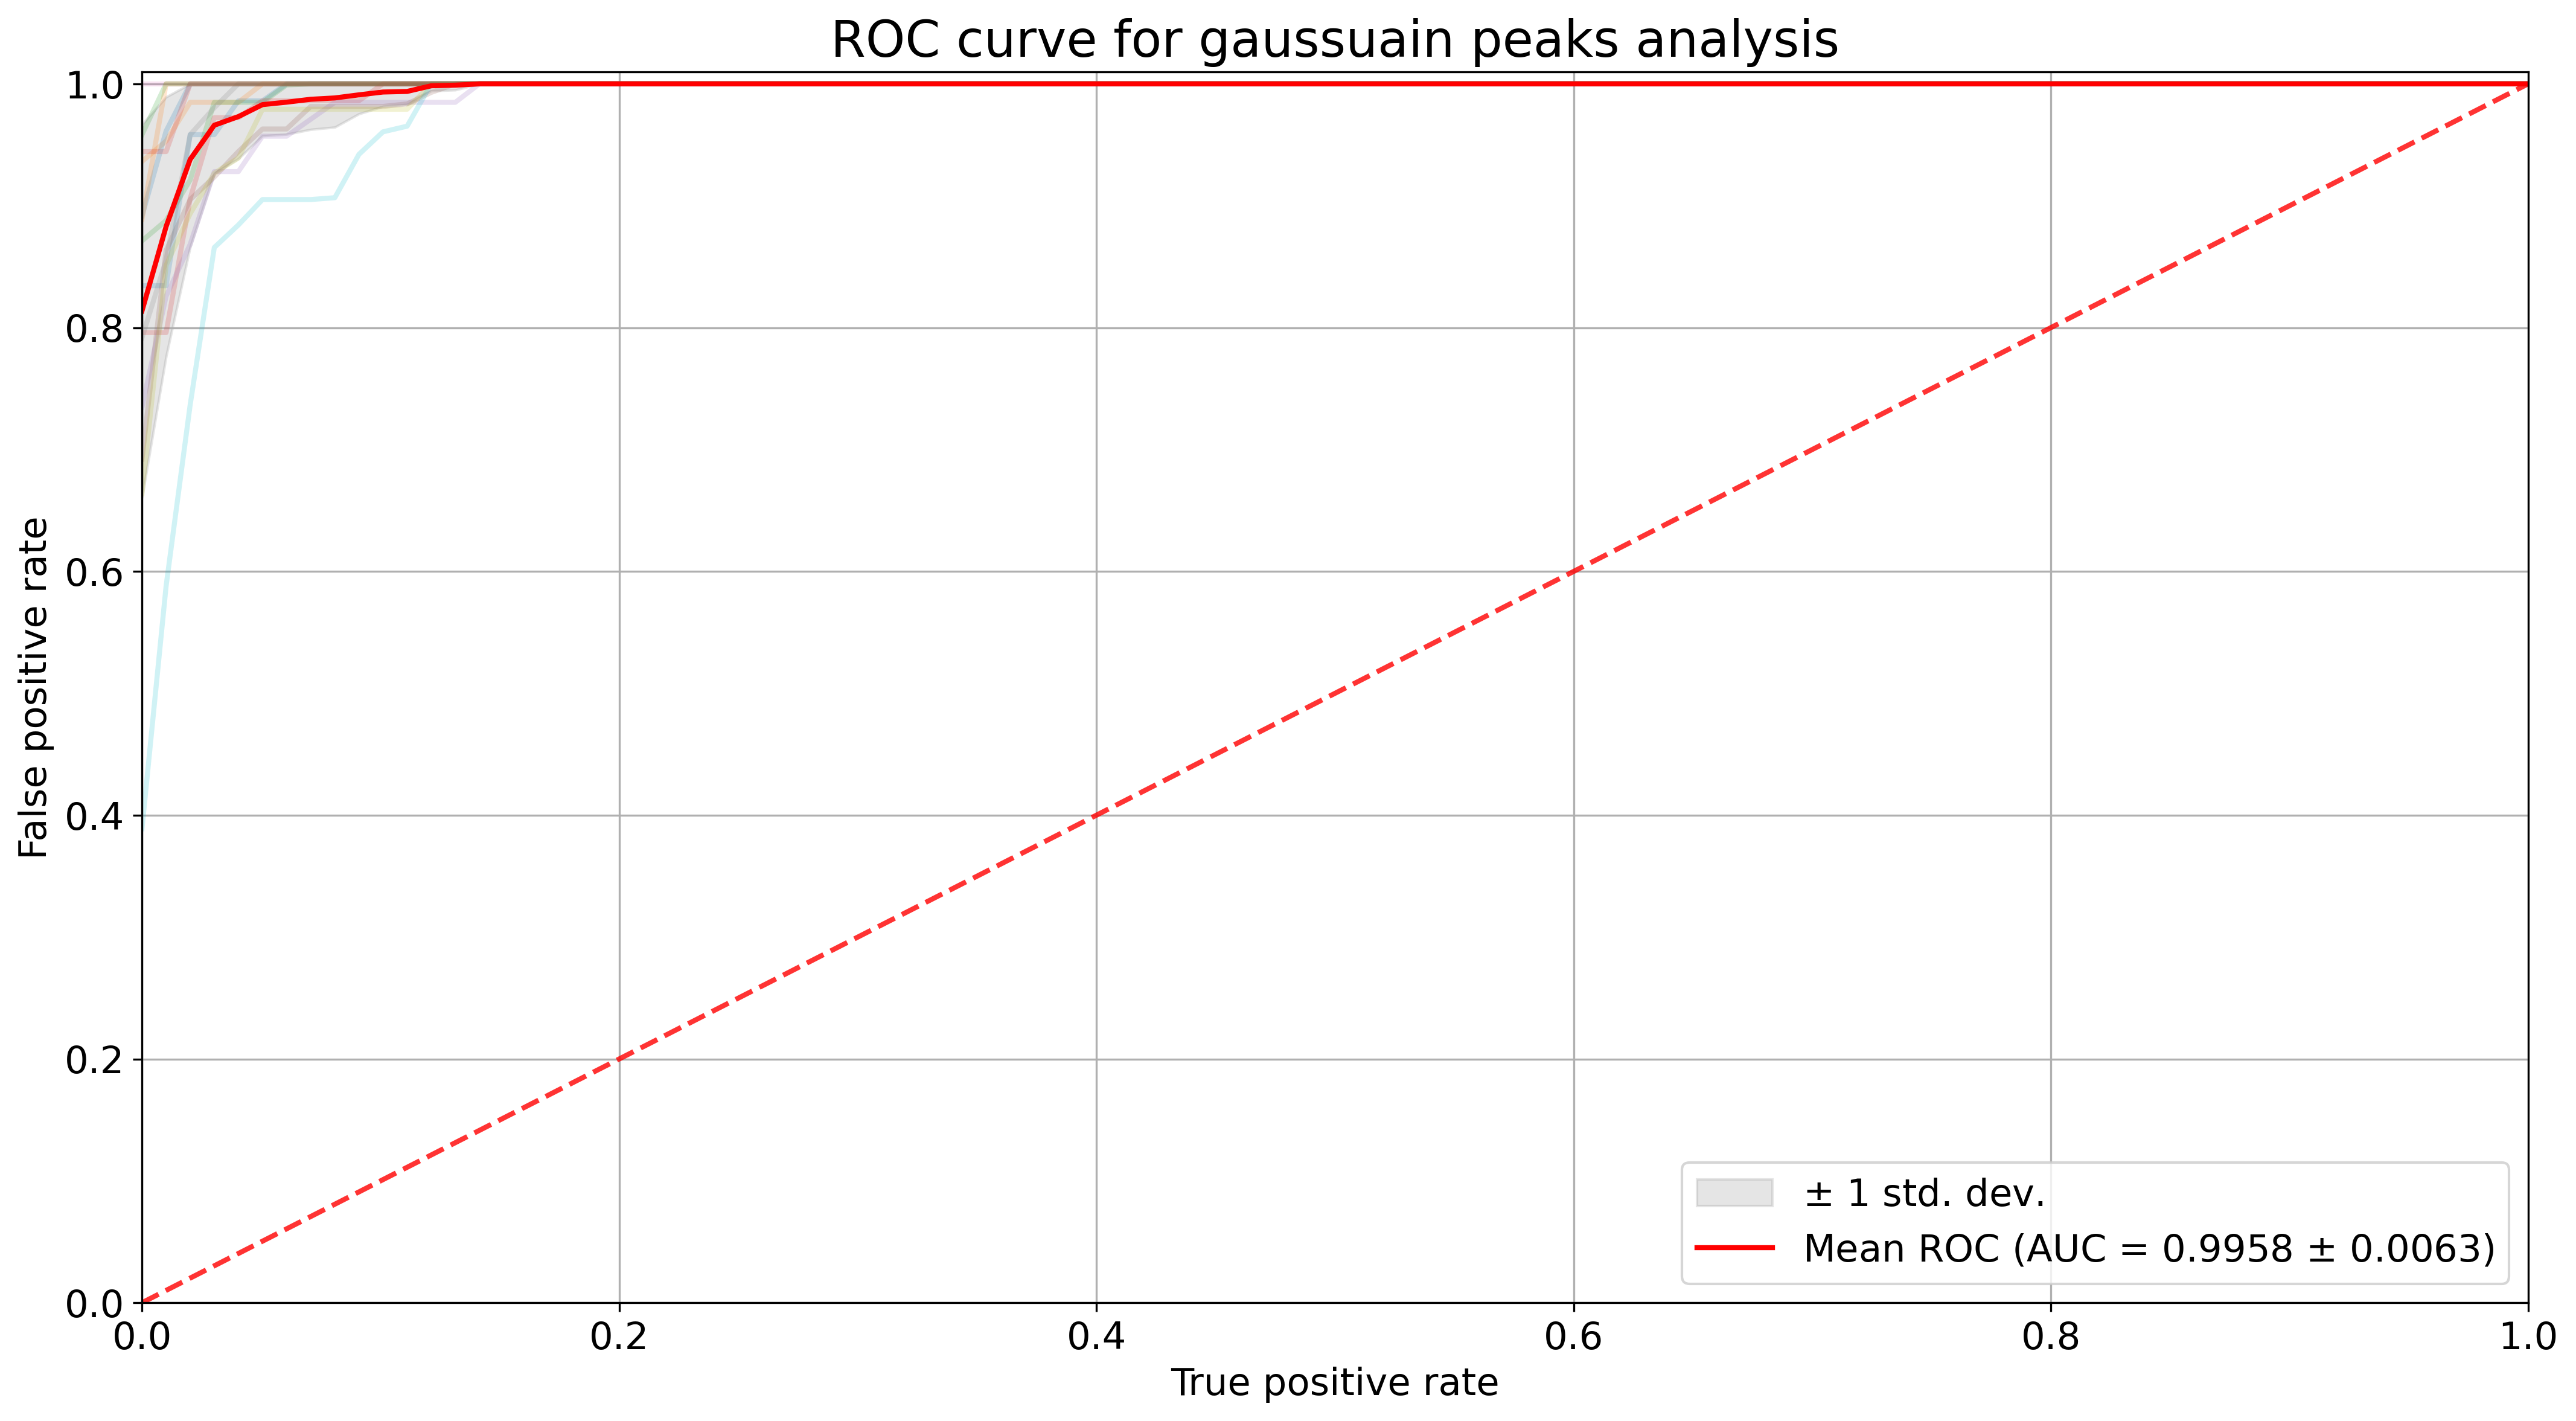

In [207]:
exrt_crystal_system = ExtraTreesClassifier(
        n_estimators=200, 
        max_depth=40, 
        max_features=X_fixed.shape[1], 
        n_jobs=-1, 
    #     random_state=random_state,
        warm_start=False
    )

print_roc(X_fixed, y_fixed, exrt_crystal_system, "gaussuain peaks", "GaussianPeaksAnalysys")

### Градиентный бустинг от XGBoost

In [121]:
# !pip install xgboost
import xgboost as xgb

def xgboost_train(data, y, num_features, description='data_cut dataset', class_type='group'):
    if class_type not in ('group', 'class'):
        raise Exception("class_type may be equal only 'group' or 'class'")
    
    xg_clsfr = xgb.XGBClassifier(
        objective='multi:softmax', 
        learning_rate = 0.01,
#         max_depth = 50, 
#         reg_alpha = 0, 
#         reg_lambda=0, 
        n_estimators = 1000, 
        eval_metric='merror'
#         num_class=7, 
#         tree_method = "hist", 
#         verbosity=0, 
#         grow_policy="lossguide"
    )
    train_template(xg_clsfr, data, y, description, class_type)

In [122]:
# in order to ignore all the warning messages
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')

# xgboost_train(X_nonfixed_cut, 
#               y_nonfixed, 
#               X_nonfixed_cut.shape[1], 
#               class_type='group', 
#               description='cut 15 peaks dataset')
# xgboost_train(X_nonfixed_cut, 
#               y_nonfixed, 
#               X_nonfixed_cut.shape[1], 
#               class_type='class', 
#               description='cut 15 peaks dataset')

# xgboost_train(X_nonfixed_filled, 
#               y_nonfixed, 
#               X_nonfixed_filled.shape[1], 
#               class_type='group', 
#               description='filled 40 peaks dataset')
# xgboost_train(X_nonfixed_filled, 
#               y_nonfixed, 
#               X_nonfixed_filled.shape[1], 
#               class_type='class', 
#               description='filled 40 peaks dataset')

xgboost_train(X_fixed, 
              y_fixed, 
              X_fixed.shape[1], 
              class_type='group', 
              description='38 peaks dataset')
xgboost_train(X_fixed, 
              y_fixed, 
              X_fixed.shape[1], 
              class_type='class', 
              description='38 peaks dataset')

mean accuracy of group prediction on 38 peaks dataset: 0.977 +- 0.01
mean accuracy of class prediction on 38 peaks dataset: 0.85 +- 0.031


### Градиентный бустинг от CatBoost

In [123]:
# !pip install catboost
import catboost

def catboost_train(data, y, num_features, description='data_cut dataset', class_type='group'):
    if class_type not in ('group', 'class'):
        raise Exception("class_type may be equal only 'group' or 'class'")
    
#     yes, I love cats
    kitty_model = catboost.CatBoostClassifier(
        iterations = 1000,
#         if you want to see logs, set 'veerbose' to 1 or 2
        verbose=0
    )
    
    train_template(kitty_model, data, y, description, class_type)

In [124]:
# in order to ignore all the warning messages
# import warnings
# warnings.filterwarnings('ignore')
# catboost_train(X_nonfixed_cut, 
#               y_nonfixed, 
#               X_nonfixed_cut.shape[1], 
#               class_type='group', 
#               description='cut 15 peaks dataset')
# catboost_train(X_nonfixed_cut, 
#               y_nonfixed, 
#               X_nonfixed_cut.shape[1], 
#               class_type='class', 
#               description='cut 15 peaks dataset')

# catboost_train(X_nonfixed_filled, 
#               y_nonfixed, 
#               X_nonfixed_filled.shape[1], 
#               class_type='group', 
#               description='filled 40 peaks dataset')
# catboost_train(X_nonfixed_filled, 
#               y_nonfixed, 
#               X_nonfixed_filled.shape[1], 
#               class_type='class', 
#               description='filled 40 peaks dataset')

catboost_train(X_fixed, 
              y_fixed, 
              X_fixed.shape[1], 
              class_type='group', 
              description='38 peaks dataset')
catboost_train(X_fixed, 
              y_fixed, 
              X_fixed.shape[1], 
              class_type='class', 
              description='38 peaks dataset')

mean accuracy of group prediction on 38 peaks dataset: 0.989 +- 0.009


KeyboardInterrupt: 

## Полные данные о гауссианах(114 фичей)

In [125]:
fixed_fg_file, fixed_ga_file = "dataSrc/peaks-fg-114nonsign.csv", "dataSrc/peaks-ga-114nonsign.csv"

data_fixed_fg = pd.read_csv(fixed_fg_file, sep=";", header=None)
data_fixed_ga = pd.read_csv(fixed_ga_file, sep=";", header=None)
columns = data_fixed_fg.columns
print(f"""data with fixed peaks FG shape: {data_fixed_fg.shape}
data with fixed peaks GA shape: {data_fixed_ga.shape}""")

data with fixed peaks FG shape: (569, 115)
data with fixed peaks GA shape: (89, 115)


In [126]:
y_fg = data_fixed_fg[columns[0]].values
print(f"old classes: {set(y_fg)}")
for index, element in enumerate(set(y_fg)):
    y_fg[y_fg == element] = index
print(f"new classes: {set(y_fg)}\n")

y_ga = data_fixed_ga[columns[0]].values
print(f"old ga classes: {set(y_ga)}")
for index, element in enumerate(set(data_fixed_ga[columns[0]])):
    y_ga[y_ga == element] = index + len(set(y_fg))
print(f"new ga classes: {set(y_ga)}")

old classes: {1, 2, 3, 4, 5, 7, 8, 9, 10, 11}
new classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

old ga classes: {2, 3, 5, 6}
new ga classes: {10, 11, 12, 13}


In [127]:
group1 = [0, 1, 2, 3, 4]
group2 = [5, 6, 7, 8, 9]
group3 = [10, 11]
group4 = [12, 13]
groups = [group1, group2, group3, group4]

def add_group(y, groups, add=0):
    new_y = np.zeros((y.shape[0], 2))
    new_y[:, 1] = y
    for group_num, group in enumerate(groups):
        for class_num in group:
            new_y[y==class_num] = np.array([group_num + add, class_num])
    return new_y

y_ga = add_group(y_ga, (group3, group4), add=2)
y_fg = add_group(y_fg, (group1, group2))
print(f"Now, shapes of y_fg and ga is respectively: {y_ga.shape}, {y_fg.shape}")

Now, shapes of y_fg and ga is respectively: (89, 2), (569, 2)


In [128]:
X_fixed = np.concatenate(
    (
    data_fixed_fg[columns[1:]],
    data_fixed_ga[columns[1:]]
    )
    , axis=0
)
y_fixed = np.concatenate(
    (
    y_fg,
    y_ga
    )
    , axis=0
)

print(f"shapes of X and y is respectively: {X_fixed.shape}, {y_fixed.shape}")

shapes of X and y is respectively: (658, 114), (658, 2)


In [129]:
def random_forest_train(data, y, num_features, description='data_cut dataset', class_type='group'):
    if class_type not in ('group', 'class'):
        raise Exception("class_type may be equal only 'group' or 'class'")
    exrt_crystal_system = ExtraTreesClassifier(
        n_estimators=2000, 
        max_depth=40, 
        max_features=num_features, 
        n_jobs=-1, 
    #     random_state=random_state,
        warm_start=False
    )
    
    train_template(exrt_crystal_system, data, y, description, class_type)

In [55]:
random_forest_train(
    X_fixed, 
    y_fixed, 
    X_fixed.shape[1], 
    class_type='group', 
    description='114 peaks dataset'
)
random_forest_train(
    X_fixed, 
    y_fixed, 
    X_fixed.shape[1], 
    class_type='class', 
    description='114 peaks dataset'
)

mean accuracy of group prediction on 114 peaks dataset: 0.997 +- 0.004
mean accuracy of class prediction on 114 peaks dataset: 0.913 +- 0.023


In [58]:
# !pip install xgboost
import xgboost as xgb

def xgboost_train(data, y, num_features, description='data_cut dataset', class_type='group'):
    if class_type not in ('group', 'class'):
        raise Exception("class_type may be equal only 'group' or 'class'")
    
    xg_clsfr = xgb.XGBClassifier(
        objective='multi:softmax', 
        learning_rate = 0.01,
#         max_depth = 50, 
#         reg_alpha = 0, 
#         reg_lambda=0, 
        n_estimators = 200, 
        eval_metric='merror'
#         num_class=7, 
#         tree_method = "hist", 
#         verbosity=0, 
#         grow_policy="lossguide"
    )
    train_template(xg_clsfr, data, y, description, class_type)

In [59]:
# in order to ignore all the warning messages
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')

xgboost_train(X_fixed, 
              y_fixed, 
              X_fixed.shape[1], 
              class_type='group', 
              description='114 peaks dataset')
xgboost_train(X_fixed, 
              y_fixed, 
              X_fixed.shape[1], 
              class_type='class', 
              description='114 peaks dataset')

mean accuracy of group prediction on 114 peaks dataset: 0.982 +- 0.011
mean accuracy of class prediction on 114 peaks dataset: 0.854 +- 0.019


In [130]:
# !pip install catboost
import catboost

def catboost_train(data, y, num_features, description='data_cut dataset', class_type='group'):
    if class_type not in ('group', 'class'):
        raise Exception("class_type may be equal only 'group' or 'class'")
    
#     yes, I love cats
    kitty_model = catboost.CatBoostClassifier(
        iterations = 200,
#         if you want to see logs, set 'veerbose' to 1 or 2
        verbose=0
    )
    
    train_template(kitty_model, data, y, description, class_type)

In [131]:
catboost_train(X_fixed, 
              y_fixed, 
              X_fixed.shape[1], 
              class_type='group', 
              description='114 peaks dataset')
catboost_train(X_fixed, 
              y_fixed, 
              X_fixed.shape[1], 
              class_type='class', 
              description='114 peaks dataset')

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

mean accuracy of group prediction on 114 peaks dataset: 0.994 +- 0.006
mean accuracy of class prediction on 114 peaks dataset: 0.927 +- 0.019


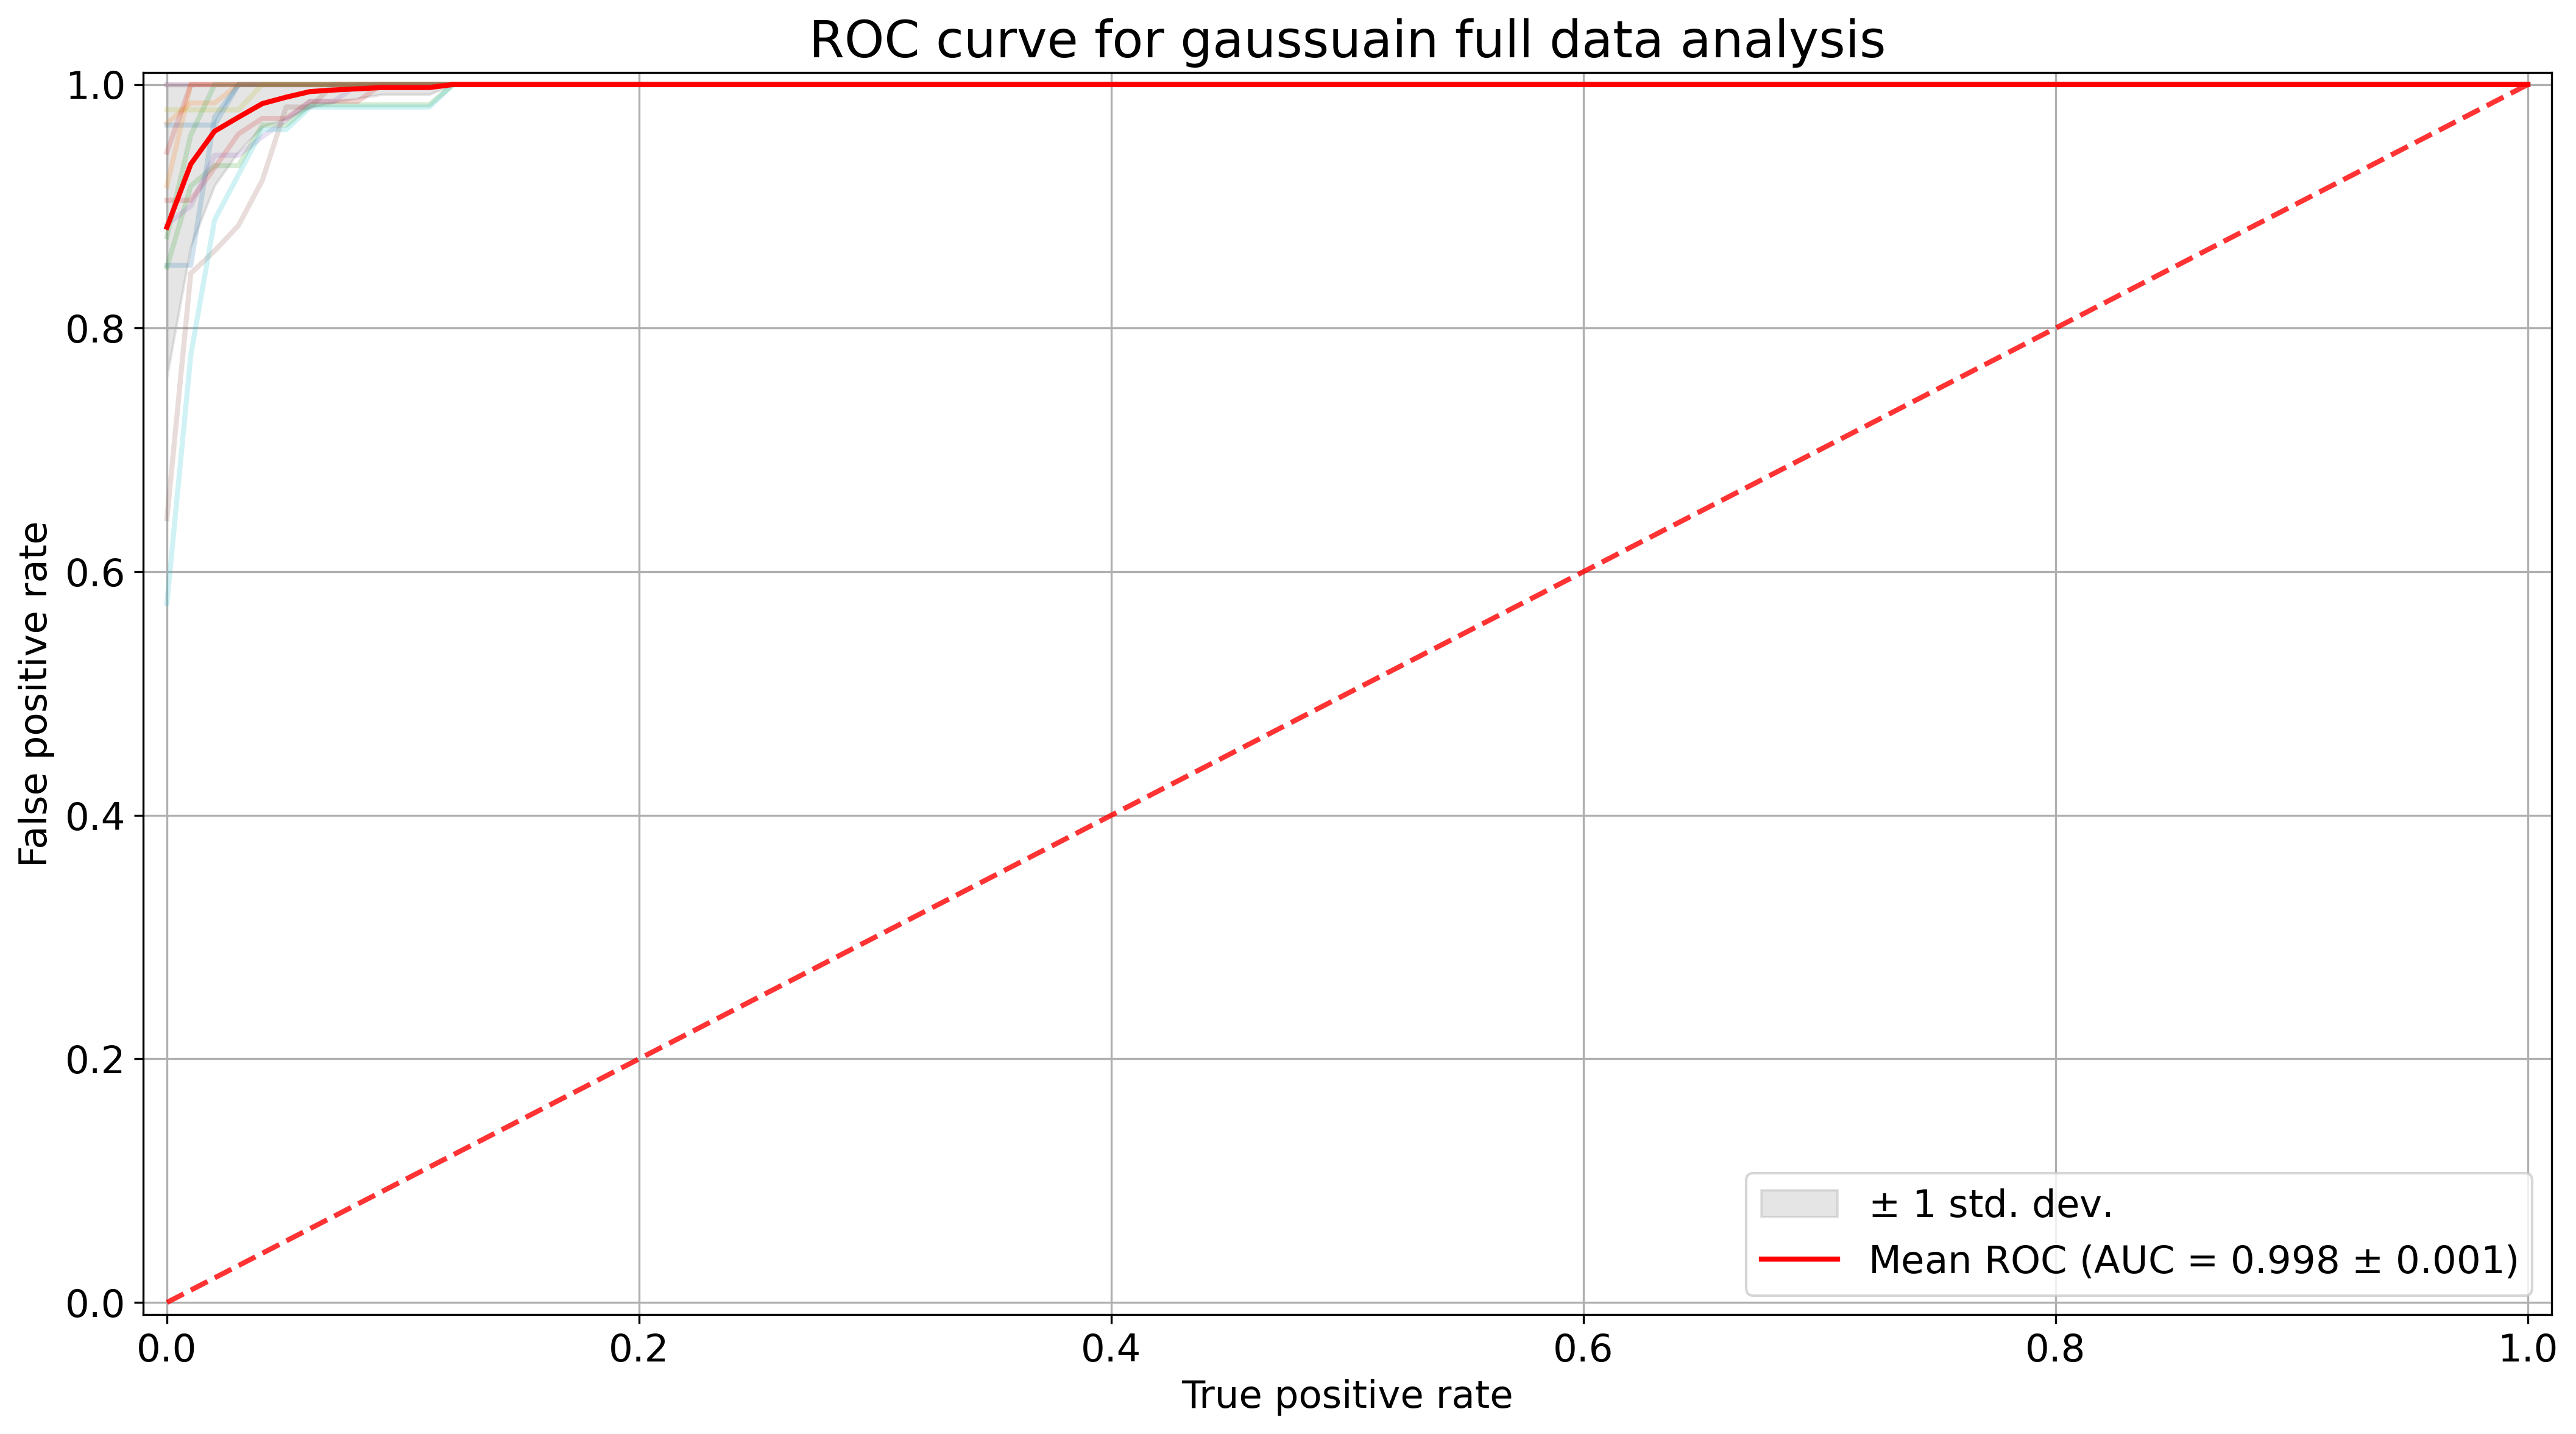

In [107]:
kitty_model = catboost.CatBoostClassifier(
        iterations = 100,
#         if you want to see logs, set 'veerbose' to 1 or 2
        verbose=0
    )

print_roc(X_fixed, y_fixed, kitty_model, "gaussuain full data", "GaussianFullDataAnalysys")

## Metrics